In [1]:
# installing required libraries in kaggle environment
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

     |████████████████████████████████| 274 kB 827 kB/s eta 0:00:01
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=23b5cbd42573d1594fcb91cea5b409061a4dbce05f4f493a1696f1ff3a5f1860
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fancyimpute 0.5.5 requires tensorflow, which is not installed.
dask-cudf 21.6.1+2.g101fc0fda4 requires cupy-cuda112, which is not installed.
libcst 0.3.19 requires pyyaml>=5.2, but you have pyyaml 5.1 which is incompatible.
featuretools 0.25.0 requires pyyaml>=5.4, but you have pyyaml 5.1 which is incompatible.


In [2]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.8")

1.8.0+cu101 True


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
# register dataset with detectron2
from detectron2.data.datasets import register_coco_instances
register_coco_instances("sherd_train_dataset", {}, "../input/sherd-dataset/training/train_annotations_coco.json", "../input/sherd-dataset/training")
register_coco_instances("sherd_val_dataset", {}, "../input/sherd-dataset/validation/val_annotations_coco.json", "../input/sherd-dataset/validation")

In [5]:
sherd_train_metadata = MetadataCatalog.get("sherd_train_dataset")
#print(sherd_train_metadata)

dataset_dicts = DatasetCatalog.get("sherd_train_dataset")
#print(dataset_dicts)

[08/19 02:11:37 d2.data.datasets.coco]: Loaded 106 images in COCO format from ../input/sherd-dataset/training/train_annotations_coco.json


In [6]:
from detectron2.engine import DefaultTrainer

# setup configuration and set hyperparameters
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sherd_train_dataset",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500 
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

# begin training model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/19 02:11:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 91.4MB/s]                              


[08/19 02:11:47 d2.engine.train_loop]: Starting training from iteration 0
[08/19 02:11:54 d2.utils.events]:  eta: 0:02:42  iter: 19  total_loss: 1.767  loss_cls: 0.6545  loss_box_reg: 0.3968  loss_mask: 0.6859  loss_rpn_cls: 0.00744  loss_rpn_loc: 0.006308  time: 0.3334  data_time: 0.0131  lr: 9.7405e-06  max_mem: 2933M
[08/19 02:12:00 d2.utils.events]:  eta: 0:02:32  iter: 39  total_loss: 1.561  loss_cls: 0.5175  loss_box_reg: 0.3674  loss_mask: 0.6456  loss_rpn_cls: 0.004034  loss_rpn_loc: 0.006979  time: 0.3305  data_time: 0.0063  lr: 1.9731e-05  max_mem: 2933M
[08/19 02:12:07 d2.utils.events]:  eta: 0:02:27  iter: 59  total_loss: 1.366  loss_cls: 0.3826  loss_box_reg: 0.354  loss_mask: 0.5452  loss_rpn_cls: 0.00209  loss_rpn_loc: 0.006262  time: 0.3351  data_time: 0.0078  lr: 2.972e-05  max_mem: 2933M
[08/19 02:12:14 d2.utils.events]:  eta: 0:02:21  iter: 79  total_loss: 1.099  loss_cls: 0.275  loss_box_reg: 0.3611  loss_mask: 0.4735  loss_rpn_cls: 0.003553  loss_rpn_loc: 0.007543 

In [7]:
# adjust configuration to include new model weights trained in previous step
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[08/19 02:14:41 d2.data.datasets.coco]: Loaded 79 images in COCO format from ../input/sherd-dataset/validation/val_annotations_coco.json


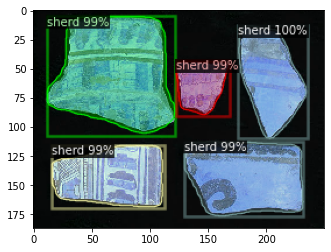

In [8]:
# perform inference on validation dataset and display image
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("sherd_val_dataset")
sherd_val_metadata = MetadataCatalog.get("sherd_val_dataset")

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sherd_val_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

In [9]:
# evaluate the model performance
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("sherd_val_dataset", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "sherd_val_dataset")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[08/19 02:14:42 d2.data.datasets.coco]: Loaded 79 images in COCO format from ../input/sherd-dataset/validation/val_annotations_coco.json
[08/19 02:14:42 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   sherd    | 428          |
|            |              |
[08/19 02:14:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/19 02:14:42 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[08/19 02:14:42 d2.data.common]: Serialized dataset takes 0.09 MiB
[08/19 02:14:42 d2.evaluation.evaluator]: Start inference on 79 batches
[08/19 02:14:43 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0013 s/iter. Inference: 0.0623 s/iter. Eval: 0.0026 s/iter. Total: 0.0661 s/iter. ETA=0:00:04
[08/19 02:14:48 d2.evaluation.evaluator]: Inference done 67/79. Da